In [29]:
import numpy as np # 数组常用库
import pandas as pd # 读入csv常用库
from patsy import dmatrices # 可根据离散变量自动生成哑变量
from sklearn.linear_model import LogisticRegression # sk-learn库Logistic Regression模型
from sklearn.model_selection import train_test_split, cross_val_score # sk-learn库训练与测试
from sklearn import metrics # 生成各项测试指标库
import matplotlib.pyplot as plt # 画图常用库


# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

> 从../input/HR_comma_sep.csv文件中读入数据，存入data

In [30]:
data = pd.read_csv("../input/HR_comma_sep.csv")
print(data.shape)
print(data.dtypes)
data.head()

(14999, 10)
satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [31]:
data.left = data.left.astype(int)

观察离职人数与工资分布的关系

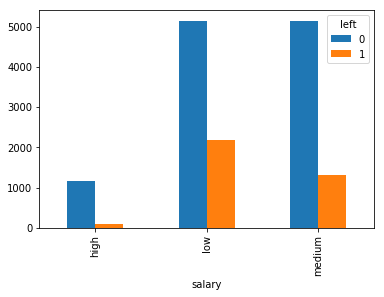

In [32]:
pd.crosstab(data.salary, data.left).plot(kind='bar')
plt.show()

观察离职比例与工资分布的关系

left       0     1
salary            
high    1155    82
low     5144  2172
medium  5129  1317
salary
high      1237
low       7316
medium    6446
dtype: int64


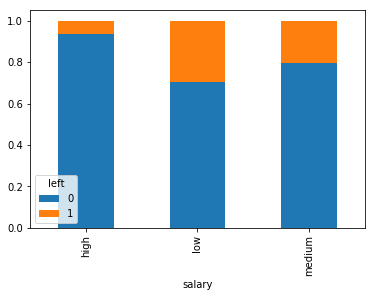

In [33]:
analysis = pd.crosstab(data.salary, data.left)
print(analysis)
print(analysis.sum(1))

analysis.div(analysis.sum(1), axis = 0).plot(kind='bar', stacked = True)
plt.show()

员工满意度分布图

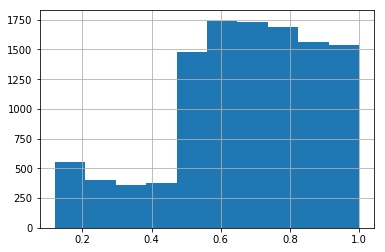

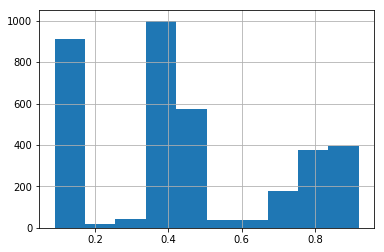

In [35]:
data[data.left==0].satisfaction_level.hist()
plt.show()

data[data.left==1].satisfaction_level.hist()
plt.show()

dmatrices将数据中的离散变量变成哑变量，并指明用satisfaction_level, last_evaluation, ... 来预测left

In [36]:
model = LogisticRegression()
y, X = dmatrices('left~satisfaction_level+last_evaluation+number_project+average_montly_hours+time_spend_company+Work_accident+promotion_last_5years+C(sales)+C(salary)', data, return_type='dataframe')

In [37]:
X = X.rename(columns = {
    'C(sales)[T.RandD]': 'Department: Random',
    'C(sales)[T.accounting]': 'Department: Accounting',
    'C(sales)[T.hr]': 'Department: HR',
    'C(sales)[T.management]': 'Department: Management',
    'C(sales)[T.marketing]': 'Department: Marketing',
    'C(sales)[T.product_mng]': 'Department: Product_Management',
    'C(sales)[T.sales]': 'Department: Sales',
    'C(sales)[T.support]': 'Department: Support',
    'C(sales)[T.technical]': 'Department: Technical',
    'C(salary)[T.low]': 'Salary: Low',
    'C(salary)[T.medium]': 'Salary: Medium'}) 
y = np.ravel(y) # 将y变成np的一维数组

用X和y训练模型，然后输出X中每一项自变量对于y的影响
zip(a,b)可将a的每一个元素和b里对应位置的元素组成一对

In [38]:
model.fit(X, y)
pd.DataFrame(list(zip(X.columns, np.transpose(model.coef_))))

,0,1
0,Intercept,[-0.6868217420025368]
1,Department: Random,[-0.4897629727374267]
2,Department: Accounting,[0.0953925494699272]
3,Department: HR,[0.3286714860865024]
4,Department: Management,[-0.40109702178917506]
5,Department: Marketing,[0.08974406178666108]
6,Department: Product_Management,[-0.040952966041304946]
7,Department: Sales,[0.07497091180239811]
8,Department: Support,[0.16836018546969445]
9,Department: Technical,[0.17302139865433502]


model.score为准确率(0到1之间)

In [39]:
print(model.score(X,y))
model.coef_

0.793652910194013


array([[-0.68682174, -0.48976297,  0.09539255,  0.32867149, -0.40109702,
         0.08974406, -0.04095297,  0.07497091,  0.16836019,  0.1730214 ,
         1.7821034 ,  1.25625654, -4.12823732,  0.73314202, -0.31413789,
         0.00424471,  0.26068841, -1.52308122, -1.08784292]])

预测这样一个人的离职概率：
一个高工资HR，
对公司满意度0.5, 
上次评审0.7分，
做过4个项目，
每月平均工作160小时，
在公司呆了3年，
过去5年没有被晋升，
没有工伤

In [40]:
model.predict_proba([[1,0,0,1,0,0,0,0,0,0,0,0, 0.5, 0.7, 4.0, 160, 3.0, 0, 0]])

array([[0.91615561, 0.08384439]])

In [41]:
model.predict_proba(X)
pred = model.predict(X)
(abs(pred-y)).sum() / len(y)

0.20634708980598707

生成7:3的训练测试集并在训练集上训练模型model2

In [42]:
Xtrain,Xtest,ytrain,ytest=train_test_split(X, y, test_size=0.3, random_state=37)
model2 = LogisticRegression()
model2.fit(Xtrain, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [43]:
model2 = LogisticRegression(C=10000)
model2.fit(Xtrain, ytrain)
pred = model2.predict(Xtest)
metrics.accuracy_score(ytest, pred)


0.79

用metrics观察实际离职/未离职被预测成为离职/未离职的数目

In [44]:
metrics.confusion_matrix(ytest, pred)

array([[3164,  251],
       [ 694,  391]])

In [45]:
print(metrics.classification_report(ytest, pred))


              precision    recall  f1-score   support

         0.0       0.82      0.93      0.87      3415
         1.0       0.61      0.36      0.45      1085

   micro avg       0.79      0.79      0.79      4500
   macro avg       0.71      0.64      0.66      4500
weighted avg       0.77      0.79      0.77      4500



10份的交叉验证Cross Validation

In [46]:
print(cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10))

[0.80746169 0.792      0.79533333 0.78733333 0.804      0.804
 0.79266667 0.79       0.74449633 0.73582388]
